# 1. VHM Dataset

In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

In [ ]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('../Datasets/1 - VHM Historical Data.csv')
df = df.iloc[::-1].reset_index(drop=True)  # Reverse the dataframe
df['Date'] = pd.to_datetime(df['Date'])
df1 = df['Price'].str.replace(',', '').astype(float)

In [ ]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [ ]:
df1

array([[0.5961768 ],
       [0.62907782],
       [0.5961768 ],
       ...,
       [0.01989179],
       [0.01094048],
       [0.00795672]])

## Ratio 9:1

In [ ]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 [==============================] - 4s 98ms/step - loss: 0.0773 - val_loss: 0.0677
Epoch 2/100
17/17 [==============================] - 2s 98ms/step - loss: 0.0135 - val_loss: 0.0185
Epoch 3/100
17/17 [==============================] - 2s 100ms/step - loss: 0.0068 - val_loss: 0.0200
Epoch 4/100
17/17 [==============================] - 1s 81ms/step - loss: 0.0038 - val_loss: 0.0087
Epoch 5/100
17/17 [==============================] - 1s 62ms/step - loss: 0.0023 - val_loss: 0.0042
Epoch 6/100
17/17 [==============================] - 1s 60ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 7/100
17/17 [==============================] - 1s 60ms/step - loss: 0.0013 - val_loss: 6.5763e-04
Epoch 8/100
17/17 [==============================] - 1s 61ms/step - loss: 0.0013 - val_loss: 4.4944e-04
Epoch 9/100
17/17 [==============================] - 1s 61ms/step - loss: 0.0012 - val_loss: 3.7218e-04
Epoch 10/100
17/17 [==============================] - 1s 62ms/step - loss: 0.0012 - val

In [ ]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

1/1 [==============================] - 0s 42ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, ytest
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
ytest = scaler.inverse_transform(ytest.reshape(-1, 1))

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred) * 100
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 597.8772571632745
Testing MAPE: 1.0019801895140674
Testing MAE: 410.0413306451613


In [ ]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

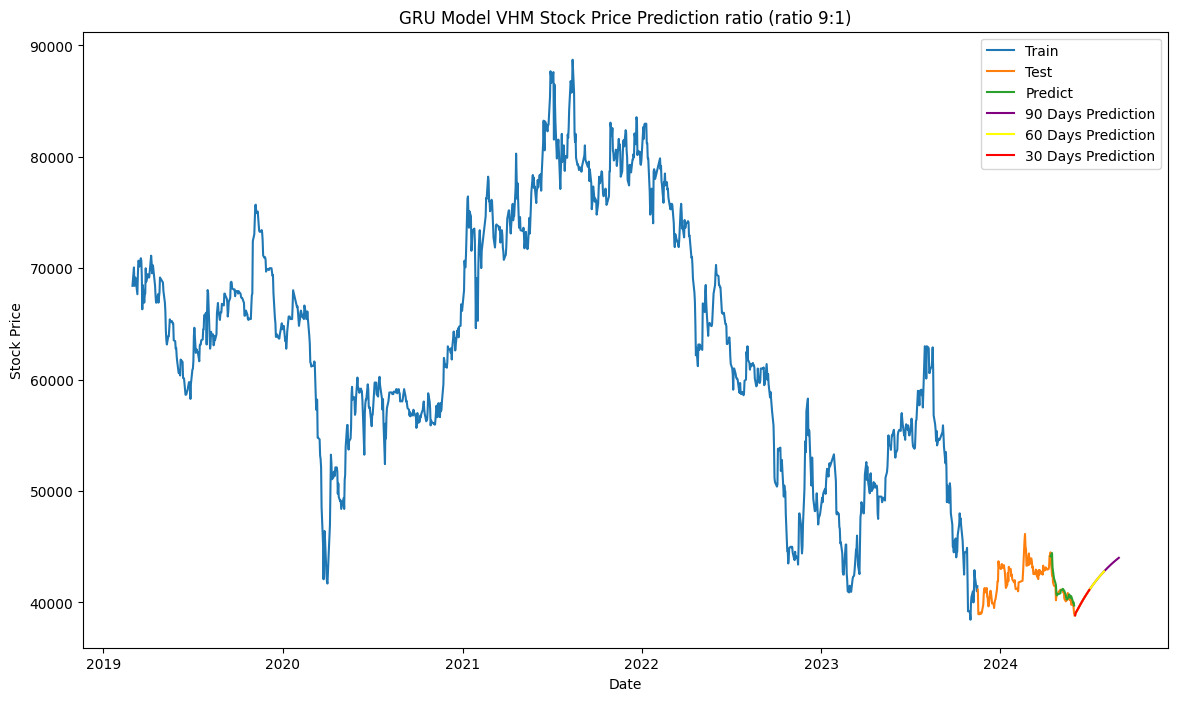

In [ ]:
# 14. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('GRU Model VHM Stock Price Prediction ratio (ratio 9:1)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()


## Ratio 8:2

In [ ]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 4s 131ms/step - loss: 0.0965 - val_loss: 0.0424
Epoch 2/100
15/15 [==============================] - 1s 91ms/step - loss: 0.0145 - val_loss: 0.0272
Epoch 3/100
15/15 [==============================] - 1s 71ms/step - loss: 0.0068 - val_loss: 0.0155
Epoch 4/100
15/15 [==============================] - 1s 54ms/step - loss: 0.0047 - val_loss: 0.0156
Epoch 5/100
15/15 [==============================] - 1s 53ms/step - loss: 0.0034 - val_loss: 0.0076
Epoch 6/100
15/15 [==============================] - 1s 55ms/step - loss: 0.0024 - val_loss: 0.0049
Epoch 7/100
15/15 [==============================] - 1s 54ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 8/100
15/15 [==============================] - 1s 54ms/step - loss: 0.0013 - val_loss: 9.1924e-04
Epoch 9/100
15/15 [==============================] - 1s 53ms/step - loss: 0.0012 - val_loss: 5.9975e-04
Epoch 10/100
15/15 [==============================] - 1s 53ms/step - loss: 0.0012 - val_los

In [ ]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

6/6 [==============================] - 0s 11ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, ytest
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
ytest = scaler.inverse_transform(ytest.reshape(-1, 1))

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred) * 100
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 853.5206867309876
Testing MAPE: 1.4563859340385163
Testing MAE: 611.6138358410494


In [ ]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

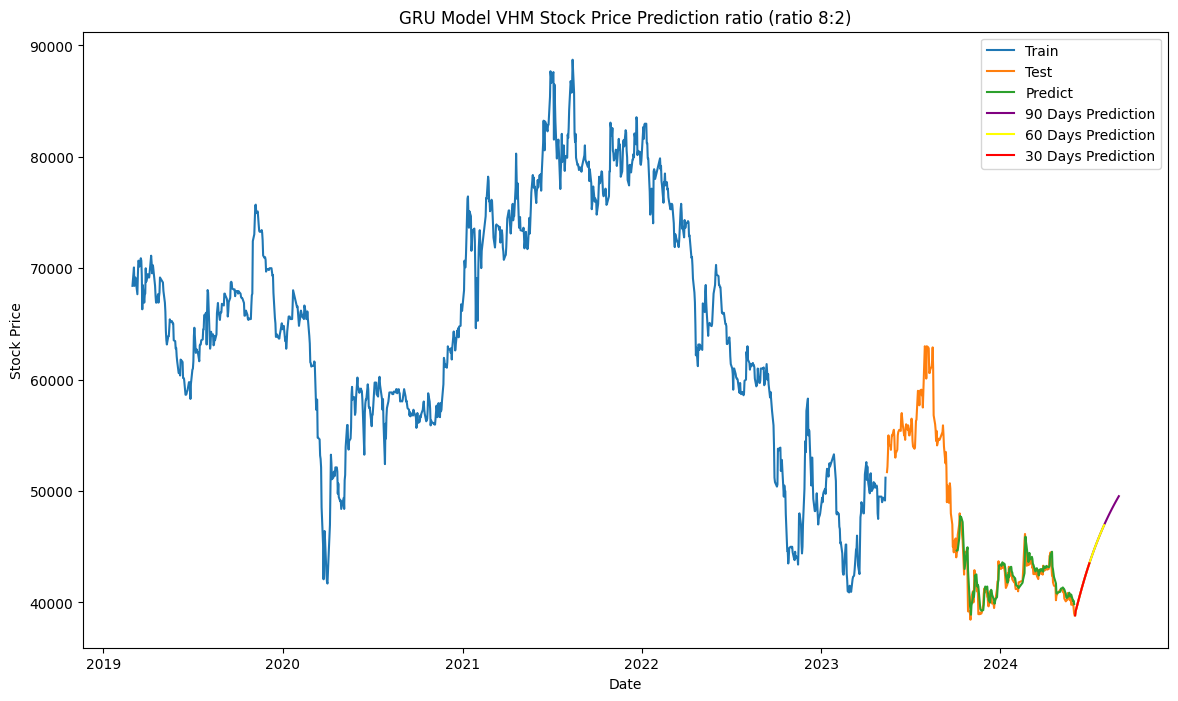

In [ ]:
# 14. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('GRU Model VHM Stock Price Prediction ratio (ratio 8:2)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()


## Ratio 7:3

In [ ]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 5s 192ms/step - loss: 0.2068 - val_loss: 0.0136
Epoch 2/100
13/13 [==============================] - 2s 150ms/step - loss: 0.0183 - val_loss: 0.0510
Epoch 3/100
13/13 [==============================] - 2s 172ms/step - loss: 0.0088 - val_loss: 0.0189
Epoch 4/100
13/13 [==============================] - 2s 136ms/step - loss: 0.0076 - val_loss: 0.0237
Epoch 5/100
13/13 [==============================] - 2s 127ms/step - loss: 0.0054 - val_loss: 0.0216
Epoch 6/100
13/13 [==============================] - 2s 128ms/step - loss: 0.0046 - val_loss: 0.0163
Epoch 7/100
13/13 [==============================] - 2s 118ms/step - loss: 0.0039 - val_loss: 0.0138
Epoch 8/100
13/13 [==============================] - 2s 147ms/step - loss: 0.0033 - val_loss: 0.0106
Epoch 9/100
13/13 [==============================] - 2s 145ms/step - loss: 0.0027 - val_loss: 0.0078
Epoch 10/100
13/13 [==============================] - 2s 150ms/step - loss: 0.0022 - val_lo

In [ ]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

10/10 [==============================] - 0s 11ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, ytest
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
ytest = scaler.inverse_transform(ytest.reshape(-1, 1))

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred) * 100
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 1139.2318936846145
Testing MAPE: 1.7739121345891242
Testing MAE: 837.8166062286691


In [ ]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

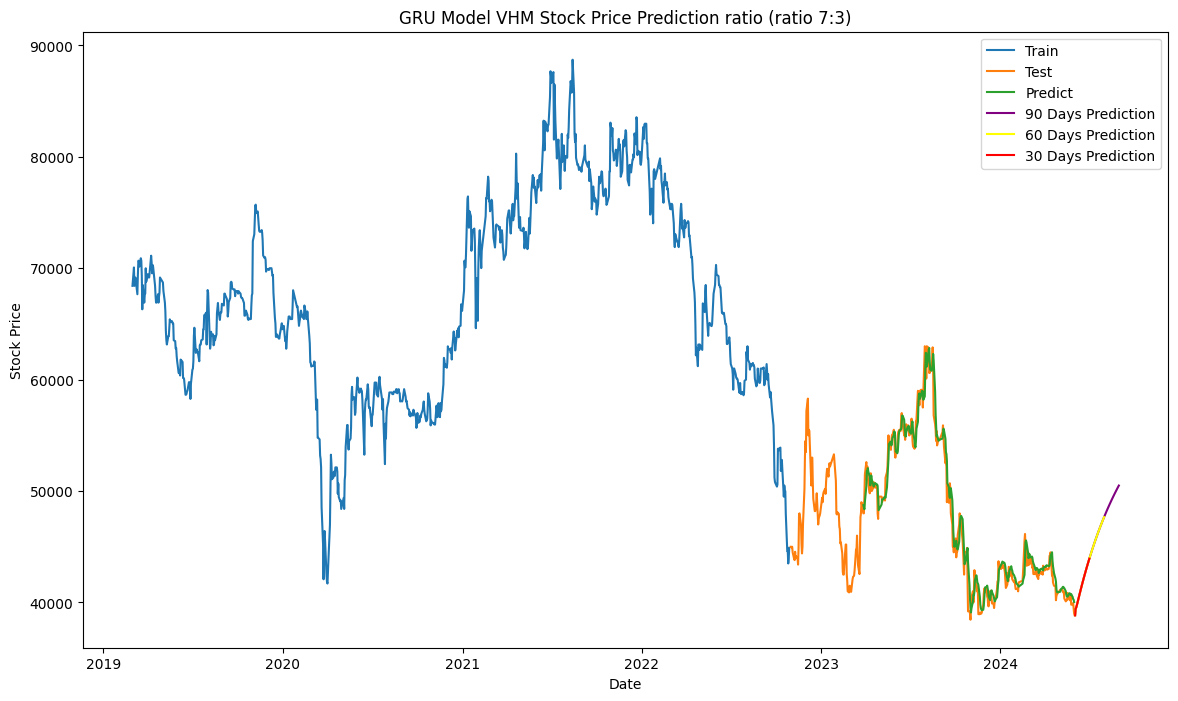

In [ ]:
# 14. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('GRU Model VHM Stock Price Prediction ratio (ratio 7:3)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()


# 2. NVL Dataset

In [39]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('2 - NVL Historical Data.csv')
df = df.iloc[::-1].reset_index(drop=True)  # Reverse the dataframe
df['Date'] = pd.to_datetime(df['Date'])
df1 = df['Price'].str.replace(',', '').astype(float)

In [40]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [41]:
df1

array([[0.27623119],
       [0.27826489],
       [0.27352769],
       ...,
       [0.04749379],
       [0.04749379],
       [0.05114716]])

## Ratio 9:1

In [42]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [43]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [44]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [45]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [46]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [47]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 [==============================] - 7s 150ms/step - loss: 0.0866 - val_loss: 0.0535
Epoch 2/100
17/17 [==============================] - 1s 84ms/step - loss: 0.0143 - val_loss: 0.0072
Epoch 3/100
17/17 [==============================] - 1s 71ms/step - loss: 0.0046 - val_loss: 0.0040
Epoch 4/100
17/17 [==============================] - 1s 49ms/step - loss: 0.0011 - val_loss: 1.2078e-04
Epoch 5/100
17/17 [==============================] - 1s 49ms/step - loss: 5.5522e-04 - val_loss: 7.6854e-05
Epoch 6/100
17/17 [==============================] - 1s 48ms/step - loss: 4.9410e-04 - val_loss: 8.0831e-05
Epoch 7/100
17/17 [==============================] - 1s 47ms/step - loss: 4.6403e-04 - val_loss: 1.0373e-04
Epoch 8/100
17/17 [==============================] - 1s 49ms/step - loss: 4.5395e-04 - val_loss: 1.1245e-04
Epoch 9/100
17/17 [==============================] - 1s 50ms/step - loss: 4.3639e-04 - val_loss: 1.1093e-04
Epoch 10/100
17/17 [==============================] - 1

In [48]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

1/1 [==============================] - 0s 478ms/step


In [49]:
# 11. Chuẩn hóa dữ liệu y_pred, ytest
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
ytest = scaler.inverse_transform(ytest.reshape(-1, 1))

In [50]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred) * 100
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 533.0853162335743
Testing MAPE: 2.656689128789051
Testing MAE: 392.6471774193547


In [51]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

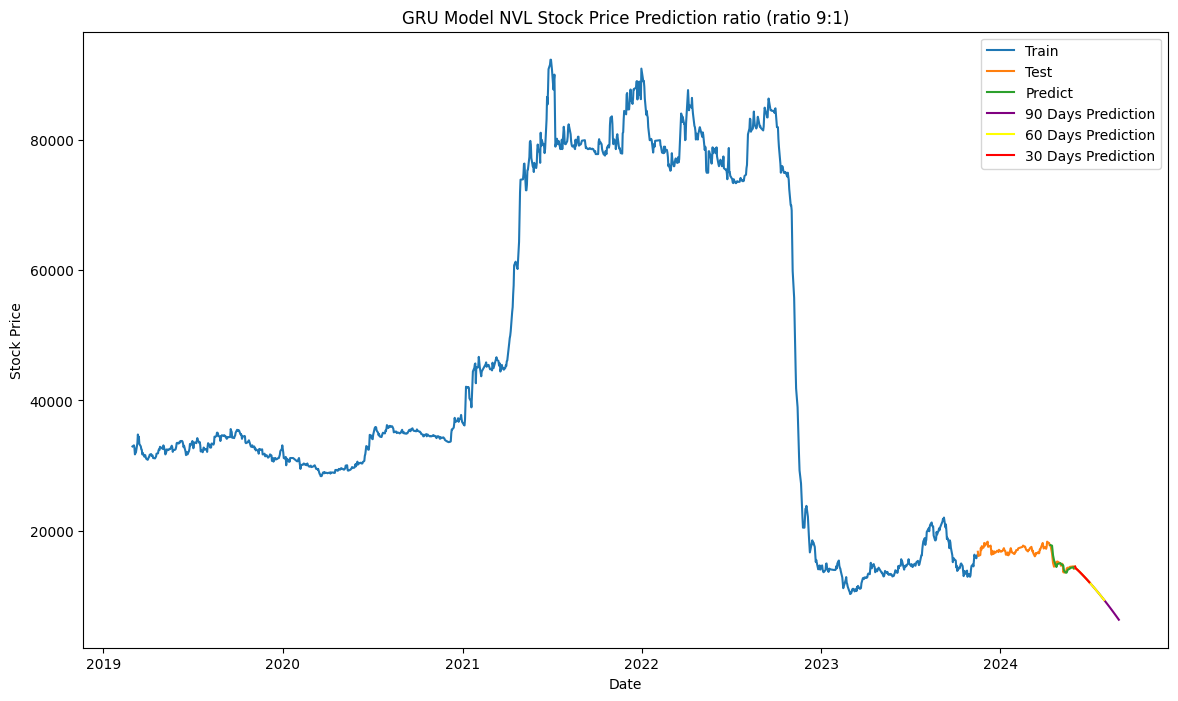

In [52]:
# 14. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('GRU Model NVL Stock Price Prediction ratio (ratio 9:1)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()


## Ratio 8:2

In [53]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [54]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [55]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [56]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [57]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [58]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 5s 118ms/step - loss: 0.1740 - val_loss: 0.0381
Epoch 2/100
15/15 [==============================] - 1s 97ms/step - loss: 0.0232 - val_loss: 0.0322
Epoch 3/100
15/15 [==============================] - 2s 101ms/step - loss: 0.0105 - val_loss: 0.0122
Epoch 4/100
15/15 [==============================] - 1s 52ms/step - loss: 0.0051 - val_loss: 0.0081
Epoch 5/100
15/15 [==============================] - 1s 58ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 6/100
15/15 [==============================] - 1s 51ms/step - loss: 8.9544e-04 - val_loss: 3.0985e-04
Epoch 7/100
15/15 [==============================] - 1s 55ms/step - loss: 6.6544e-04 - val_loss: 7.3106e-05
Epoch 8/100
15/15 [==============================] - 1s 60ms/step - loss: 6.3916e-04 - val_loss: 6.7354e-05
Epoch 9/100
15/15 [==============================] - 1s 59ms/step - loss: 6.1508e-04 - val_loss: 7.8094e-05
Epoch 10/100
15/15 [==============================] - 1s 53ms/step

In [59]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

6/6 [==============================] - 0s 10ms/step


In [60]:
# 11. Chuẩn hóa dữ liệu y_pred, ytest
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
ytest = scaler.inverse_transform(ytest.reshape(-1, 1))

In [61]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred) * 100
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 578.7215880075199
Testing MAPE: 2.8911533079415705
Testing MAE: 458.6298828125


In [62]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

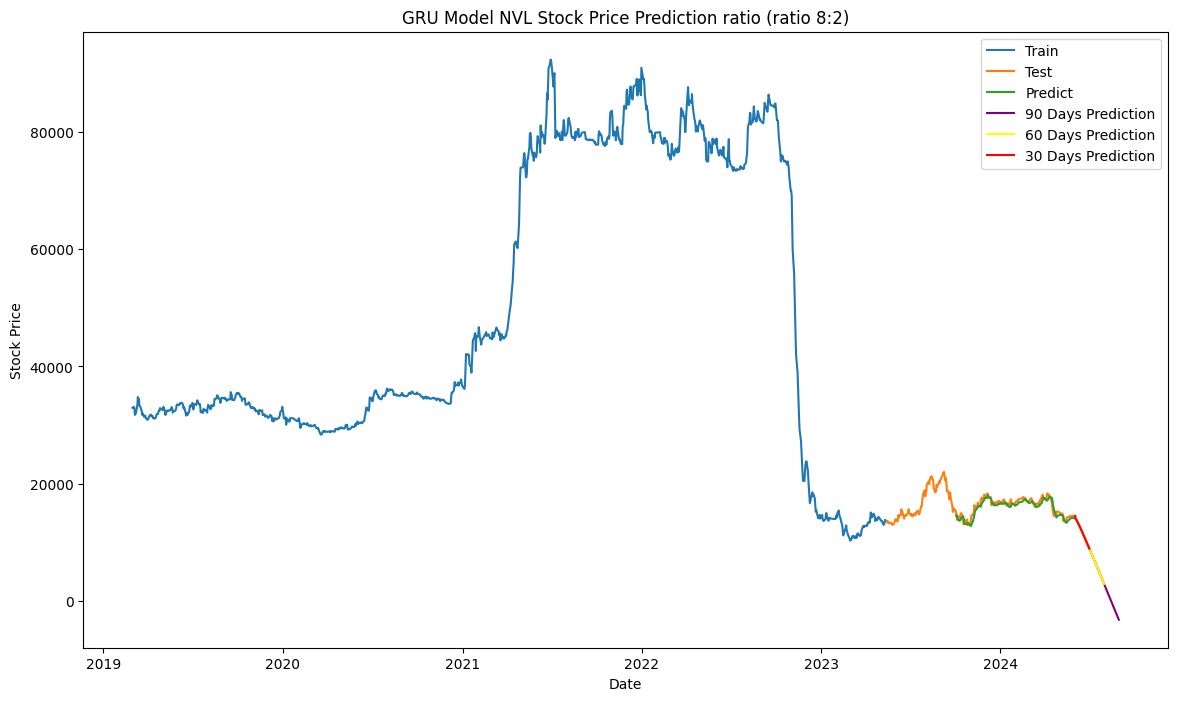

In [63]:
# 14. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('GRU Model NVL Stock Price Prediction ratio (ratio 8:2)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

## Ratio 7:3

In [64]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [65]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [66]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [67]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [68]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [69]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 4s 150ms/step - loss: 0.0833 - val_loss: 0.0374
Epoch 2/100
13/13 [==============================] - 1s 92ms/step - loss: 0.0149 - val_loss: 0.0156
Epoch 3/100
13/13 [==============================] - 1s 57ms/step - loss: 0.0063 - val_loss: 0.0103
Epoch 4/100
13/13 [==============================] - 1s 58ms/step - loss: 0.0030 - val_loss: 0.0087
Epoch 5/100
13/13 [==============================] - 1s 58ms/step - loss: 0.0017 - val_loss: 0.0032
Epoch 6/100
13/13 [==============================] - 1s 53ms/step - loss: 9.0989e-04 - val_loss: 0.0017
Epoch 7/100
13/13 [==============================] - 1s 56ms/step - loss: 5.2808e-04 - val_loss: 4.9086e-04
Epoch 8/100
13/13 [==============================] - 1s 60ms/step - loss: 3.9358e-04 - val_loss: 2.3907e-04
Epoch 9/100
13/13 [==============================] - 1s 56ms/step - loss: 3.7694e-04 - val_loss: 1.5081e-04
Epoch 10/100
13/13 [==============================] - 1s 54ms/step - lo

In [70]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

10/10 [==============================] - 1s 11ms/step


In [71]:
# 11. Chuẩn hóa dữ liệu y_pred, ytest
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
ytest = scaler.inverse_transform(ytest.reshape(-1, 1))

In [72]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred) * 100
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 596.1038497764791
Testing MAPE: 2.7119775006571363
Testing MAE: 436.7817066179607


In [73]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

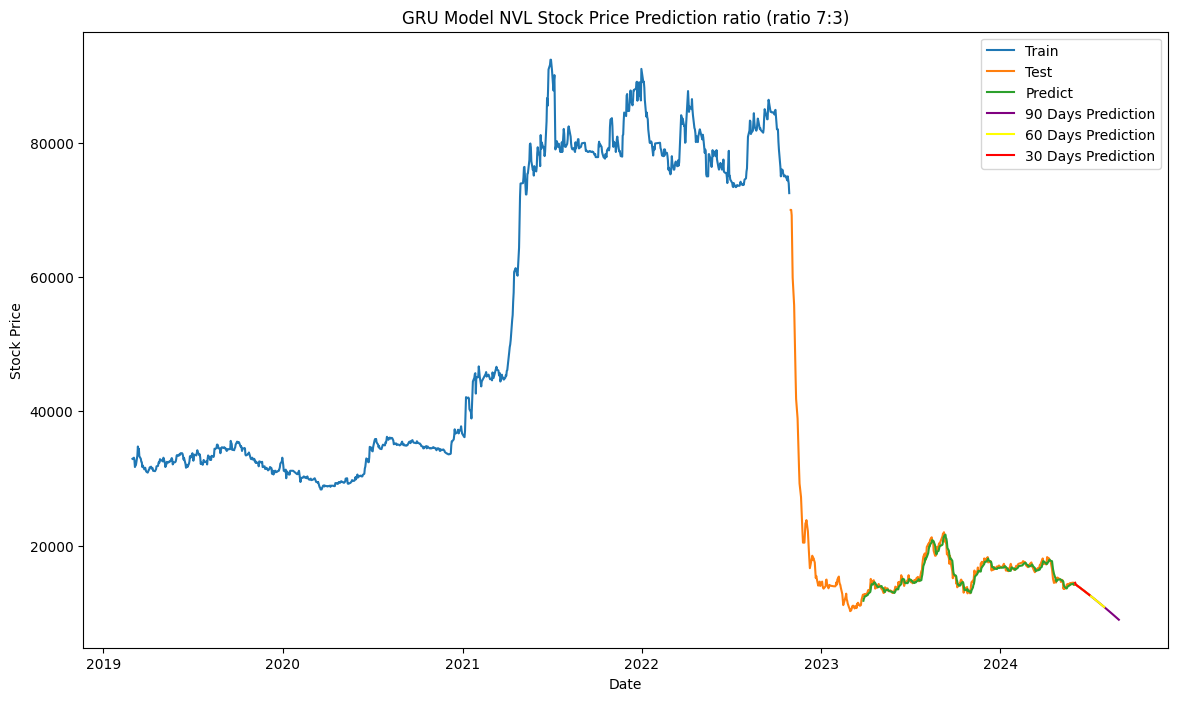

In [74]:
# 14. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('GRU Model NVL Stock Price Prediction ratio (ratio 7:3)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

# 3. NLG Dataset

In [ ]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('../Datasets/3 - NLG Historical Data.csv')
df = df.iloc[::-1].reset_index(drop=True)  # Reverse the dataframe
df['Date'] = pd.to_datetime(df['Date'])
df1 = df['Price'].str.replace(',', '').astype(float)

In [ ]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [ ]:
df1

array([[0.08706471],
       [0.09559049],
       [0.0913276 ],
       ...,
       [0.60812666],
       [0.59393056],
       [0.6000146 ]])

## Ratio 9:1

In [ ]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 [==============================] - 4s 91ms/step - loss: 0.0610 - val_loss: 0.0059
Epoch 2/100
17/17 [==============================] - 1s 77ms/step - loss: 0.0127 - val_loss: 0.0090
Epoch 3/100
17/17 [==============================] - 1s 81ms/step - loss: 0.0044 - val_loss: 0.0014
Epoch 4/100
17/17 [==============================] - 1s 54ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 5/100
17/17 [==============================] - 1s 47ms/step - loss: 8.9726e-04 - val_loss: 0.0014
Epoch 6/100
17/17 [==============================] - 1s 48ms/step - loss: 8.2464e-04 - val_loss: 0.0013
Epoch 7/100
17/17 [==============================] - 1s 50ms/step - loss: 7.8552e-04 - val_loss: 0.0012
Epoch 8/100
17/17 [==============================] - 1s 49ms/step - loss: 7.5984e-04 - val_loss: 0.0012
Epoch 9/100
17/17 [==============================] - 1s 48ms/step - loss: 7.3498e-04 - val_loss: 0.0012
Epoch 10/100
17/17 [==============================] - 1s 46ms/step - loss: 7.275

In [ ]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

1/1 [==============================] - 0s 392ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, ytest
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
ytest = scaler.inverse_transform(ytest.reshape(-1, 1))

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred) * 100
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 1213.7881467716404
Testing MAPE: 2.380505122323572
Testing MAE: 970.9245211693549


In [ ]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

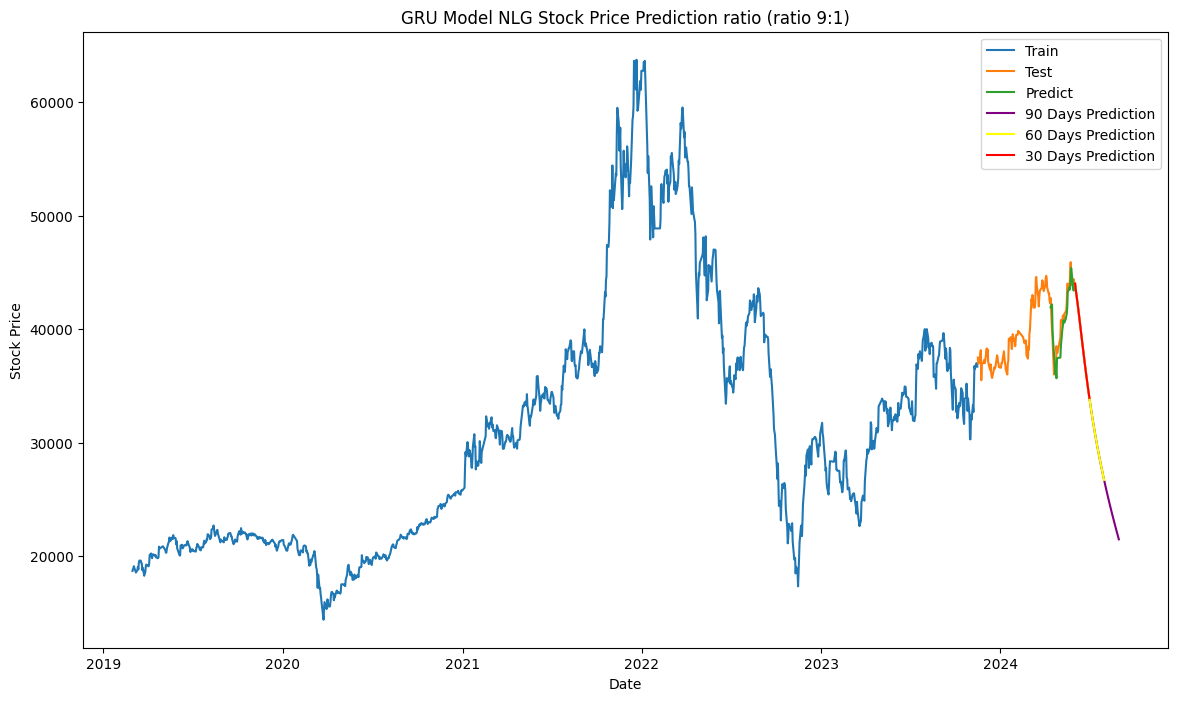

In [ ]:
# 14. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('GRU Model NLG Stock Price Prediction ratio (ratio 9:1)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()


## Ratio 8:2

In [ ]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 4s 126ms/step - loss: 0.0342 - val_loss: 0.0069
Epoch 2/100
15/15 [==============================] - 1s 92ms/step - loss: 0.0076 - val_loss: 0.0046
Epoch 3/100
15/15 [==============================] - 1s 63ms/step - loss: 0.0027 - val_loss: 8.5595e-04
Epoch 4/100
15/15 [==============================] - 1s 51ms/step - loss: 0.0010 - val_loss: 8.7937e-04
Epoch 5/100
15/15 [==============================] - 1s 48ms/step - loss: 8.3377e-04 - val_loss: 6.8530e-04
Epoch 6/100
15/15 [==============================] - 1s 48ms/step - loss: 7.8824e-04 - val_loss: 6.4874e-04
Epoch 7/100
15/15 [==============================] - 1s 53ms/step - loss: 7.4603e-04 - val_loss: 7.4842e-04
Epoch 8/100
15/15 [==============================] - 1s 49ms/step - loss: 7.3009e-04 - val_loss: 6.2100e-04
Epoch 9/100
15/15 [==============================] - 1s 50ms/step - loss: 7.0170e-04 - val_loss: 6.1669e-04
Epoch 10/100
15/15 [==============================]

In [ ]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

6/6 [==============================] - 0s 9ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, ytest
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
ytest = scaler.inverse_transform(ytest.reshape(-1, 1))

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred) * 100
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 939.9322441416911
Testing MAPE: 1.8389494502350383
Testing MAE: 695.4591893325618


In [ ]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

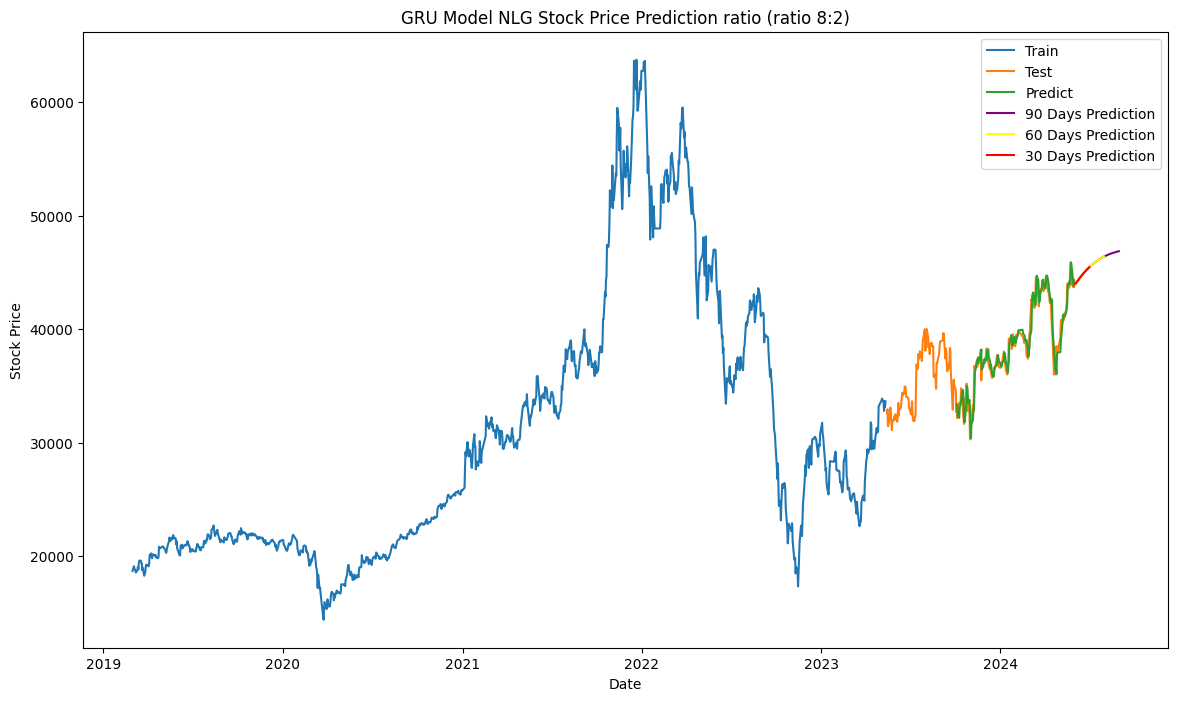

In [ ]:
# 14. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('GRU Model NLG Stock Price Prediction ratio (ratio 8:2)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()


## Ratio 7:3

In [ ]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 3s 91ms/step - loss: 0.1039 - val_loss: 0.0024
Epoch 2/100
13/13 [==============================] - 1s 54ms/step - loss: 0.0219 - val_loss: 0.0022
Epoch 3/100
13/13 [==============================] - 1s 54ms/step - loss: 0.0097 - val_loss: 0.0038
Epoch 4/100
13/13 [==============================] - 1s 56ms/step - loss: 0.0045 - val_loss: 0.0010
Epoch 5/100
13/13 [==============================] - 1s 50ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 6/100
13/13 [==============================] - 1s 55ms/step - loss: 0.0010 - val_loss: 8.2420e-04
Epoch 7/100
13/13 [==============================] - 1s 52ms/step - loss: 9.4743e-04 - val_loss: 8.6457e-04
Epoch 8/100
13/13 [==============================] - 1s 55ms/step - loss: 8.9868e-04 - val_loss: 8.1419e-04
Epoch 9/100
13/13 [==============================] - 1s 87ms/step - loss: 8.5971e-04 - val_loss: 7.7957e-04
Epoch 10/100
13/13 [==============================] - 1s 85ms/step - los

In [ ]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

10/10 [==============================] - 0s 13ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, ytest
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
ytest = scaler.inverse_transform(ytest.reshape(-1, 1))

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred) * 100
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 1016.7706955540921
Testing MAPE: 2.0843926402575716
Testing MAE: 748.4736628093003


In [ ]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

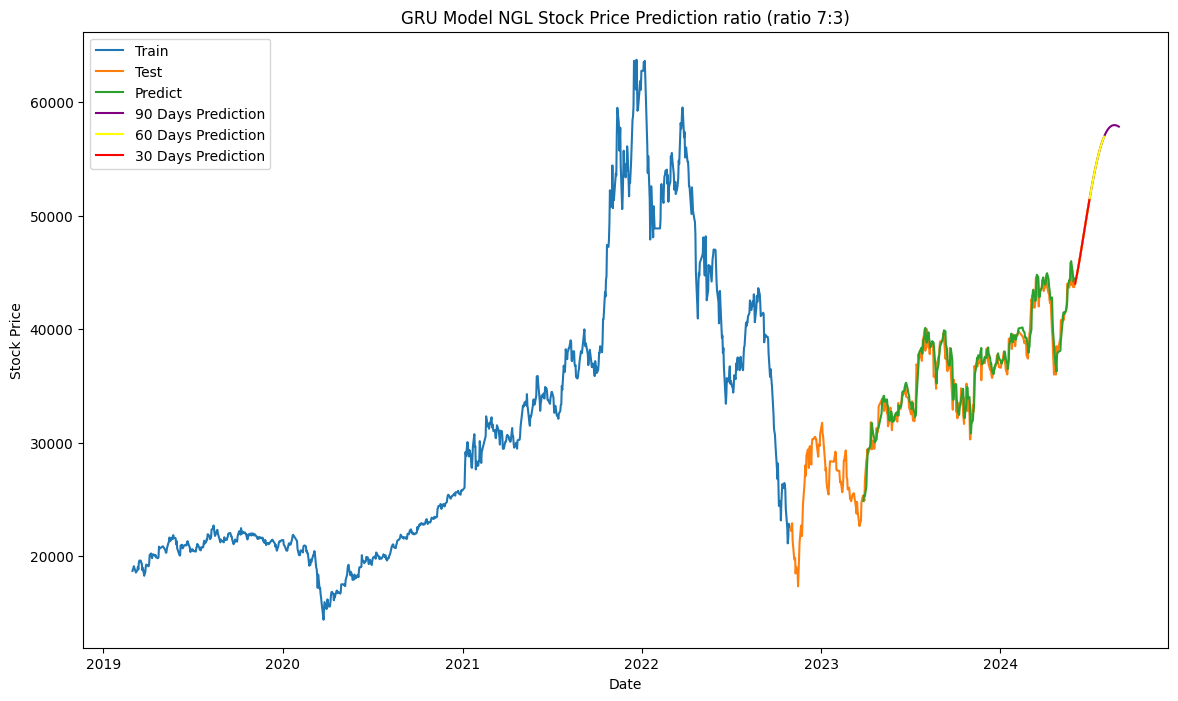

In [ ]:
# 14. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('GRU Model NGL Stock Price Prediction ratio (ratio 7:3)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()
